<a href="https://colab.research.google.com/github/sayakpaul/robustness-vit/blob/master/imagenet_results/imagenet_r/ViT_ImageNet_R_Assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Clone repository and pull latest changes.
![ -d vision_transformer ] || git clone --depth=1 https://github.com/google-research/vision_transformer
!cd vision_transformer && git pull

Cloning into 'vision_transformer'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 25 (delta 1), reused 11 (delta 0), pack-reused 0
Unpacking objects: 100% (25/25), done.
Already up to date.


In [ ]:
!pip install -qr vision_transformer/vit_jax/requirements.txt

     |████████████████████████████████| 61kB 5.4MB/s 
     |████████████████████████████████| 153kB 10.9MB/s 
     |████████████████████████████████| 92kB 7.8MB/s 
     |████████████████████████████████| 20.1MB 1.2MB/s 
     |████████████████████████████████| 137.4MB 83kB/s 
     |████████████████████████████████| 4.3MB 54.8MB/s 
     |████████████████████████████████| 460kB 49.3MB/s 
ERROR: tensorflow 2.4.1 has requirement numpy~=1.19.2, but you'll have numpy 1.18.5 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement tensorflow-estimator<2.5.0,>=2.4.0, but you'll have tensorflow-estimator 2.3.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [ ]:
import flax
import jax
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import tqdm
import pickle
import os

# Shows the number of available devices.
# In a CPU/GPU runtime this will be a single device.
# In a TPU runtime this will be 8 cores.
jax.local_devices()

[GpuDevice(id=0)]

In [ ]:
import sys
if './vision_transformer' not in sys.path:
  sys.path.append('./vision_transformer')

%load_ext autoreload
%autoreload 2

from vit_jax import checkpoint
from vit_jax import hyper
from vit_jax import input_pipeline
from vit_jax import logging
from vit_jax import models
from vit_jax import momentum_clip
from vit_jax import train

logger = logging.setup_logger('./logs')

In [ ]:
dataset = 'imagenet_r'
batch_size = 128  # Reduce to 256 if running on a single GPU.

Just add `imagenet_r` in `input_pipeline.py` (`DATASET_PRESETS`). 

In [ ]:
num_classes = input_pipeline.get_dataset_info(dataset, 'test')['num_classes']
ds_test = input_pipeline.get_data(
    dataset=dataset, mode='test', repeats=1, batch_size=batch_size,
)

2021-03-21 12:48:02,509 [INFO] absl: Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: imagenet_r/0.1.0
2021-03-21 12:48:03,056 [INFO] absl: Load dataset info from /tmp/tmp1m4x9ky5tfds
2021-03-21 12:48:03,063 [INFO] absl: Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: imagenet_r/0.1.0
2021-03-21 12:48:03,279 [INFO] absl: Load dataset info from /tmp/tmpdye1cuh7tfds
2021-03-21 12:48:03,286 [INFO] absl: Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: imagenet_r/0.1.0
2021-03-21 12:48:03,498 [INFO] absl: Load dataset info from /tmp/tmpr8943hcdtfds
2021-03-21 12:48:03,504 [INFO] absl: Generating dataset imagenet_r (/root/tensorflow_datasets/imagenet_r/0.1.0)


2021-03-21 12:48:03,881 [INFO] absl: Downloading https://people.eecs.berkeley.edu/~hendrycks/imagenet-r.tar into /root/tensorflow_datasets/downloads/people.eecs.berkele.edu_hendryc_imagene-rqxdQ5FvCVnAAEyS18oi8UzWsH9VeqJthEWSUDPgt1Ro.tar.tmp.0335cb69d2344c3496c75e0933de679c...
2021-03-21 12:59:06,848 [INFO] absl: Generating split test


Shuffling and writing examples to /root/tensorflow_datasets/imagenet_r/0.1.0.incompleteOY1F9Q/imagenet_r-test.tfrecord


2021-03-21 13:00:58,122 [INFO] absl: Done writing /root/tensorflow_datasets/imagenet_r/0.1.0.incompleteOY1F9Q/imagenet_r-test.tfrecord. Shard lengths: [938, 937, 937, 938, 938, 937, 937, 938, 938, 937, 937, 938, 938, 937, 937, 938, 938, 937, 937, 938, 938, 937, 937, 938, 938, 937, 937, 938, 938, 937, 937, 938]
2021-03-21 13:01:01,162 [INFO] absl: Skipping computing stats for mode ComputeStatsMode.SKIP.
2021-03-21 13:01:01,170 [INFO] absl: Constructing tf.data.Dataset for split test, from /root/tensorflow_datasets/imagenet_r/0.1.0


Dataset imagenet_r downloaded and prepared to /root/tensorflow_datasets/imagenet_r/0.1.0. Subsequent calls will reuse this data.


In [ ]:
batch = next(iter(ds_test.as_numpy_iterator()))
batch['image'].shape

(1, 128, 384, 384, 3)

In [ ]:
def get_accuracy(model_repl, param_repl):
    acc_1 = []
    acc_5 = []

    steps = input_pipeline.get_dataset_info(dataset, 'test')['num_examples'] // batch_size

    for _, batch in zip(tqdm.notebook.trange(steps), ds_test.as_numpy_iterator()):
        predicted = model_repl(param_repl, batch["image"])
        predicted = flax.nn.softmax(predicted)
        batch_top_1_acc = tf.keras.metrics.CategoricalAccuracy()(
            batch["label"].squeeze(), 
            predicted.squeeze()
        ).numpy()
        batch_top_5_acc = tf.keras.metrics.TopKCategoricalAccuracy(k=5)(
            batch["label"].squeeze(), 
            predicted.squeeze()
        ).numpy()
        acc_1.append(batch_top_1_acc)
        acc_5.append(batch_top_5_acc)

    return np.mean(acc_1), np.mean(acc_5)

In [ ]:
def load_model(model, ckpt_path):
    VisionTransformer = models.KNOWN_MODELS[model].partial(num_classes=1000)
    # Load and convert pretrained checkpoint.
    params = checkpoint.load(ckpt_path)
    params['pre_logits'] = {}  # Need to restore empty leaf for Flax.
    params_repl = flax.jax_utils.replicate(params)
    vit_apply_repl = jax.pmap(VisionTransformer.call)

    return vit_apply_repl, params_repl

In [ ]:
variants = [
    "ViT-B_16",
    "ViT-B_32",
    "ViT-L_16",
    "ViT-L_32",
]

In [ ]:
top_1_accs = {}
top_5_accs = {}

for variant in variants:
    print(f"Evaluating {variant}")
    # Download model pre-trained on imagenet21k and fine-tuned on imagenet2012.
    ![ -e "$variant"_imagenet2012.npz ] || gsutil cp gs://vit_models/imagenet21k+imagenet2012/"$variant".npz "$variant"_imagenet2012.npz
    model_repl, param_repl = load_model(variant, variant + "_imagenet2012.npz")
    
    acc_1, acc_5 = get_accuracy(model_repl, param_repl)
    print(f"Top-1 accuracy: {acc_1*100}%")
    print(f"Top-5 accuracy: {acc_5*100}%")
    top_1_accs[variant] = acc_1
    top_5_accs[variant] = acc_5

    os.remove(variant + "_imagenet2012.npz")


Evaluating ViT-B_16
Copying gs://vit_models/imagenet21k+imagenet2012/ViT-B_16.npz...
| [1 files][331.4 MiB/331.4 MiB]                                                
Operation completed over 1 objects/331.4 MiB.                                    


2021-03-21 13:02:27,718 [INFO] absl: Load dataset info from /root/tensorflow_datasets/imagenet_r/0.1.0



Top-1 accuracy: 38.014155626297%
Top-5 accuracy: 53.04487347602844%
Evaluating ViT-B_32
Copying gs://vit_models/imagenet21k+imagenet2012/ViT-B_32.npz...
| [1 files][336.9 MiB/336.9 MiB]                                                
Operation completed over 1 objects/336.9 MiB.                                    


2021-03-21 13:25:14,641 [INFO] absl: Load dataset info from /root/tensorflow_datasets/imagenet_r/0.1.0



Top-1 accuracy: 31.800881028175354%
Top-5 accuracy: 45.26909589767456%
Evaluating ViT-L_16
Copying gs://vit_models/imagenet21k+imagenet2012/ViT-L_16.npz...
\ [1 files][  1.1 GiB/  1.1 GiB]   62.5 MiB/s                                   
Operation completed over 1 objects/1.1 GiB.                                      


2021-03-21 13:31:14,176 [INFO] absl: Load dataset info from /root/tensorflow_datasets/imagenet_r/0.1.0



Top-1 accuracy: 40.614983439445496%
Top-5 accuracy: 56.80088400840759%
Evaluating ViT-L_32
Copying gs://vit_models/imagenet21k+imagenet2012/ViT-L_32.npz...
\ [1 files][  1.1 GiB/  1.1 GiB]   72.0 MiB/s                                   
Operation completed over 1 objects/1.1 GiB.                                      


2021-03-21 14:33:50,344 [INFO] absl: Load dataset info from /root/tensorflow_datasets/imagenet_r/0.1.0



Top-1 accuracy: 34.361645579338074%
Top-5 accuracy: 48.68122339248657%


In [ ]:
f = open("top_1_imagnet_r_vit.pkl", "wb")
f.write(pickle.dumps(top_1_accs))
f.close()
     
f = open("top_5_imagnet_r_vit.pkl", "wb")
f.write(pickle.dumps(top_5_accs))
f.close()

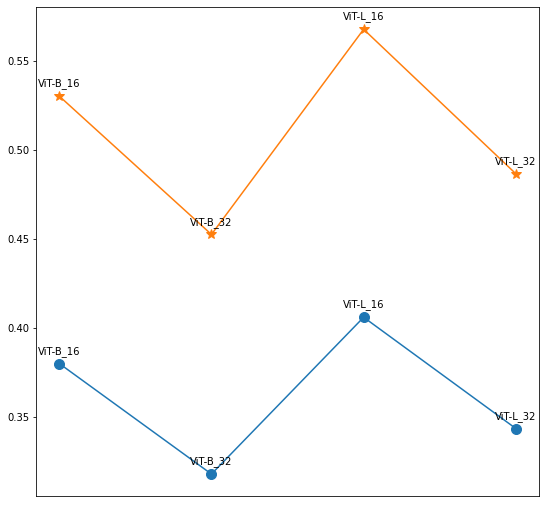

In [ ]:
plt.figure(figsize=(9, 9))
plt.plot(list(top_1_accs.values()), marker=".", markersize=20)
plt.plot(list(top_5_accs.values()), marker="*", markersize=10)
xs = np.arange(0, 5, 1)

# Reference: https://queirozf.com/entries/add-labels-and-text-to-matplotlib-plots-annotation-examples
for i, (x, y) in enumerate(zip(xs, top_1_accs.values())):
    label = list(top_1_accs.keys())[i]
    plt.annotate(label, # this is the text
         (x, y), # this is the point to label
         textcoords="offset points", # how to position the text
         xytext=(0, 10), # distance from text to points (x,y)
         ha='center') # horizontal alignment can be left, right or center
    
for i, (x, y) in enumerate(zip(xs, top_5_accs.values())):
    label = list(top_1_accs.keys())[i]
    plt.annotate(label, # this is the text
         (x, y), # this is the point to label
         textcoords="offset points", # how to position the text
         xytext=(0, 10), # distance from text to points (x,y)
         ha='center') # horizontal alignment can be left, right or center
plt.xticks([])
plt.savefig("imagenet_r_vit.png", dpi=300, bbox_inches="tight")